In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import string



In [3]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data = pd.read_csv('C:/kifiya ai/stock-market-predictions/src/data/raw_analyst_ratings.csv')
sample_data = data.head(100000)
sample_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
sample_data['headline_length'] = sample_data['headline'].apply(len)
length_stats = sample_data['headline_length'].describe()
print("Headline Length Statistics:\n", length_stats)
# data.head()

Headline Length Statistics:
 count    100000.000000
mean         73.639590
std          40.465787
min           7.000000
25%          47.000000
50%          65.000000
75%          88.000000
max         458.000000
Name: headline_length, dtype: float64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\2240821819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['headline_length'] = sample_data['headline'].apply(len)


In [6]:
sample_data['date'] = pd.to_datetime(sample_data['date'],  errors='coerce')
publisher_counts = sample_data['publisher'].value_counts()
print("\nArticles per Publisher:\n", publisher_counts)



Articles per Publisher:
 publisher
Paul Quintaro                   16791
Lisa Levin                      14137
Benzinga Newsdesk               10856
Charles Gross                    6523
Monica Gerson                    6181
                                ...  
Khyathi Dalal                       1
Tom Meilleur                        1
Josh Wolonick                       1
Brian Sozzi                         1
David Russell - TradeStation        1
Name: count, Length: 522, dtype: int64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\1336996196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['date'] = pd.to_datetime(sample_data['date'],  errors='coerce')


In [7]:
sample_data['day_of_week'] = sample_data['date'].dt.day_name()
daily_counts = sample_data.groupby('day_of_week').size()
print("\nPublication Trends by Day:\n", daily_counts)
sample_data.head()



Publication Trends by Day:
 day_of_week
Friday       609
Monday       701
Saturday      10
Sunday        28
Thursday     813
Tuesday      750
Wednesday    775
dtype: int64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\1316017299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['day_of_week'] = sample_data['date'].dt.day_name()


,Unnamed: 0,headline,url,publisher,date,stock,headline_length,day_of_week
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,Tuesday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,Friday
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,Friday


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\3531297061.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='viridis')


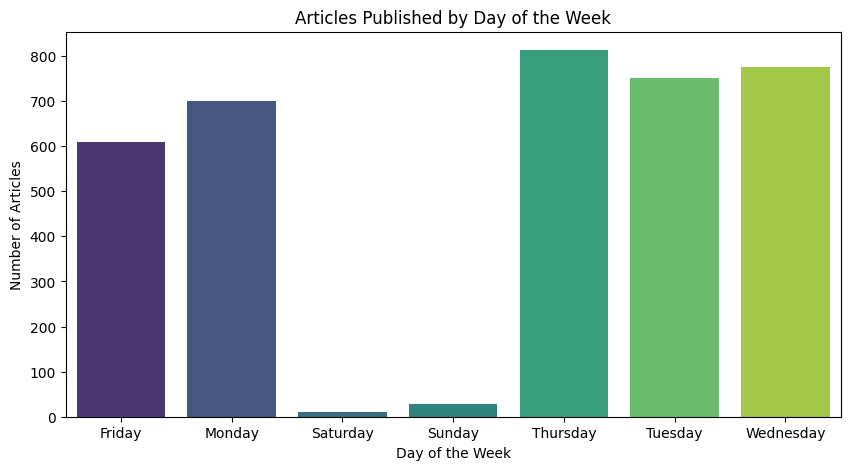

In [8]:
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_counts.index, y=daily_counts.values, palette='viridis')
plt.title("Articles Published by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Articles")
plt.show()

In [9]:
def assign_sentiment_label(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return 'Neutral'

sample_data['sentiment_label'] = sample_data['headline'].apply(lambda headline: assign_sentiment_label(TextBlob(headline).sentiment.polarity))
sample_data.head()


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\285549136.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['sentiment_label'] = sample_data['headline'].apply(lambda headline: assign_sentiment_label(TextBlob(headline).sentiment.polarity))


,Unnamed: 0,headline,url,publisher,date,stock,headline_length,day_of_week,sentiment_label
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,Friday,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,Wednesday,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,Tuesday,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,Friday,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,Friday,Neutral


In [10]:

# Download stopwords
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing to the headlines
sample_data['cleaned_headline'] = sample_data['headline'].apply(preprocess_text)
sample_data.head()

C:\Users\Home\AppData\Local\Temp\ipykernel_19348\1981651339.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['cleaned_headline'] = sample_data['headline'].apply(preprocess_text)


,Unnamed: 0,headline,url,publisher,date,stock,headline_length,day_of_week,sentiment_label,cleaned_headline
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,Friday,Neutral,stocks hit 52week highs friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,Wednesday,Neutral,stocks hit 52week highs wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,Tuesday,Neutral,71 biggest movers friday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,Friday,Neutral,46 stocks moving fridays midday session
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,Friday,Neutral,b securities maintains neutral agilent technol...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Create TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20, ngram_range=(1, 2))  # Extract unigrams and bigrams
tfidf_matrix = tfidf.fit_transform(sample_data['cleaned_headline'])

# Get top keywords
tfidf_keywords = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print("Top Keywords for the Data:")
print(tfidf_keywords.sum().sort_values(ascending=False).head(10))


Top Keywords for the Data:
stocks       10819.554467
shares        6049.593121
earnings      5556.067675
top           4997.381503
reports       4874.198940
market        4738.146757
update        4734.476768
announces     4526.449745
vs            4376.761747
eps           4303.934034
dtype: float64


In [13]:
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(sample_data['cleaned_headline'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X)

# Display topics
for i, topic in enumerate(lda.components_):
    topic_keywords = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]  # Top 10 words per topic
    print(f"Topic {i+1}: {', '.join(topic_keywords)}")


Topic 1: yesterday, maintains, morgan, target, price, biggest, movers, downgrades, upgrades, benzingas
Topic 2: q2, q4, sees, scheduled, sales, reports, earnings, eps, est, vs
Topic 3: earnings, higher, shares, markets, market, trading, stocks, session, moving, premarket
Topic 4: update, pharmaceuticals, american, bank, coverage, initiates, capital, pt, buy, announces
Topic 5: morning, lows, industry, new, highs, hit, midday, market, 52week, stocks


In [16]:


# Assuming your data has 'published_time' as a timestamp column

# Extract time components
sample_data['to_date'] = sample_data['date'].dt.date
sample_data['to_hour'] = sample_data['date'].dt.hour
sample_data['to_day_of_week'] = sample_data['date'].dt.day_name()

# Group by date for daily frequency
daily_publications = sample_data.groupby('date').size()


date
2011-04-29 13:47:06-04:00    1
2011-05-02 03:24:46-04:00    1
2011-06-07 09:49:32-04:00    1
2011-06-07 10:19:24-04:00    1
2011-06-10 14:06:14-04:00    1
                            ..
2020-06-10 13:18:50-04:00    1
2020-06-10 13:37:18-04:00    1
2020-06-10 15:09:50-04:00    1
2020-06-10 15:13:10-04:00    1
2020-06-10 15:17:32-04:00    1
Length: 3151, dtype: int64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\2675013332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['to_date'] = sample_data['date'].dt.date
C:\Users\Home\AppData\Local\Temp\ipykernel_19348\2675013332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['to_hour'] = sample_data['date'].dt.hour
C:\Users\Home\AppData\Local\Temp\ipykernel_19348\2675013332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

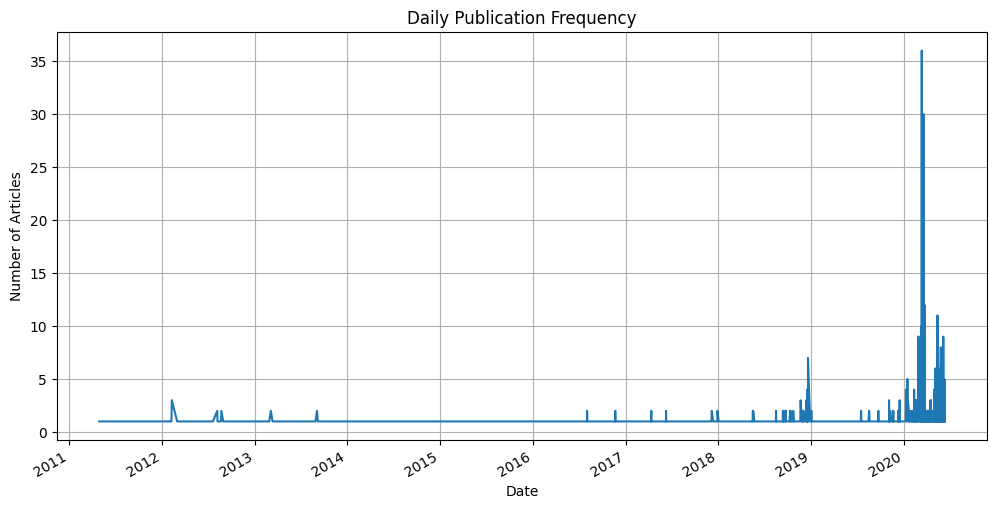

In [17]:
plt.figure(figsize=(12, 6))
daily_publications.plot(kind='line', title='Daily Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()


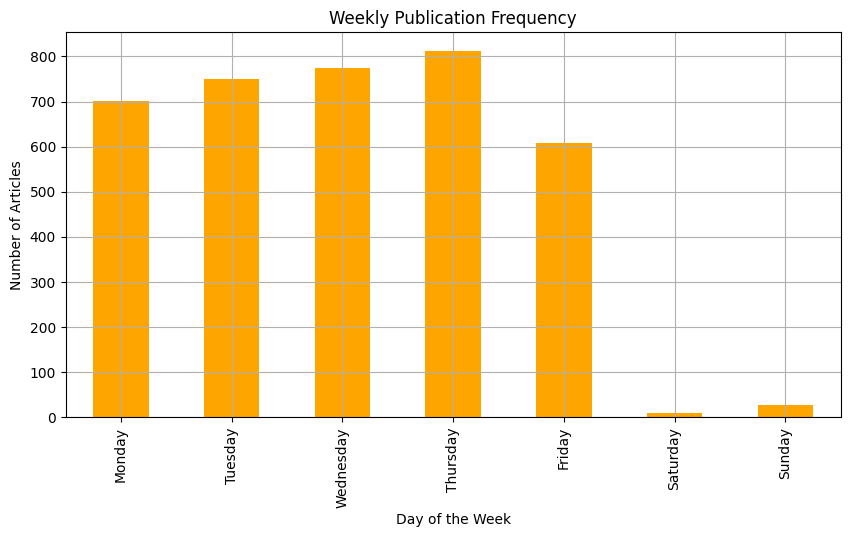

In [18]:
# Group by day of the week
weekly_publications = sample_data.groupby('day_of_week').size()

plt.figure(figsize=(10, 5))
weekly_publications.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(
    kind='bar', color='orange', title='Weekly Publication Frequency'
)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.grid()
plt.show()


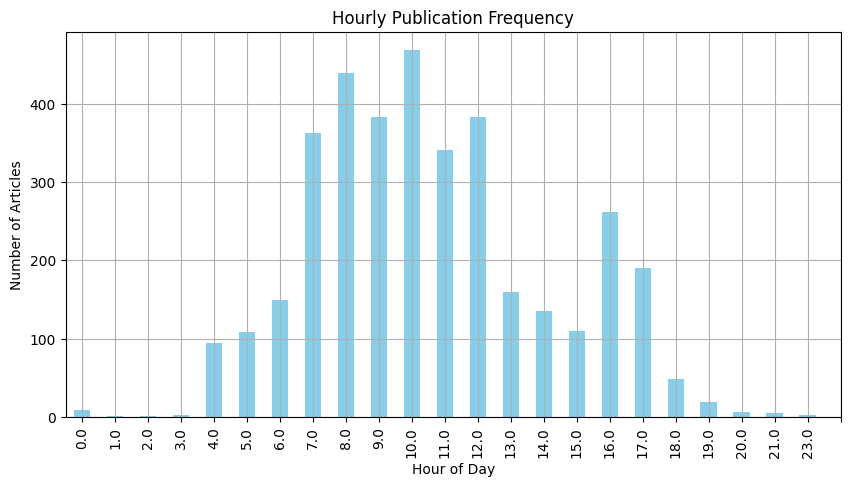

In [21]:
# Group by hour
hourly_publications = sample_data.groupby('to_hour').size()

plt.figure(figsize=(10, 5))
hourly_publications.plot(kind='bar', color='skyblue', title='Hourly Publication Frequency')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles')
plt.xticks(range(24))
plt.grid()
plt.show()


In [22]:
# Count articles by publisher
top_publishers = sample_data['publisher'].value_counts().head(10)

print(top_publishers)


publisher
Paul Quintaro        16791
Lisa Levin           14137
Benzinga Newsdesk    10856
Charles Gross         6523
Monica Gerson         6181
Eddie Staley          4256
Hal Lindon            3706
Benzinga Staff        2368
Juan Lopez            2130
Vick Meyer            2130
Name: count, dtype: int64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\239190892.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_publisher_data['category'] = top_publisher_data['headline'].apply(categorize_article)


publisher          category             
Benzinga Newsdesk  Financial Performance    2744
                   General Updates           964
                   Market Trends            4757
                   Other                    2391
Benzinga Staff     Financial Performance     655
                   General Updates           191
                   Market Trends              93
                   Other                    1429
Charles Gross      Financial Performance    1110
                   General Updates           367
                   Market Trends             678
                   Other                    4368
Eddie Staley       Financial Performance    1497
                   General Updates           280
                   Market Trends             242
                   Other                    2237
Hal Lindon         Financial Performance    1221
                   General Updates           346
                   Market Trends             418
                   Other    

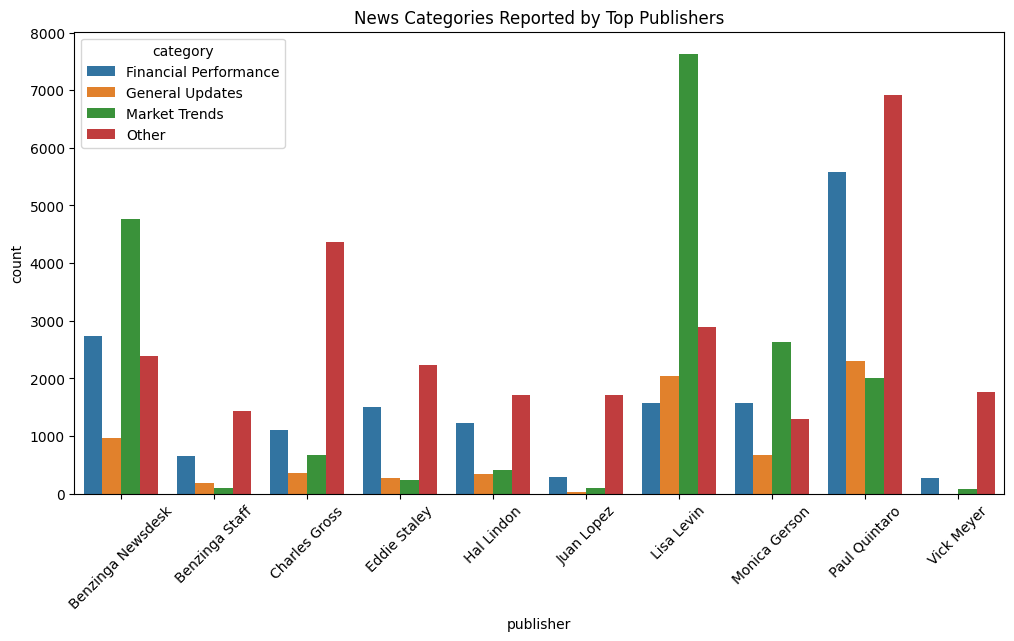

In [25]:
# Get the list of top 10 publishers
top_publisher_list = top_publishers.index

# Filter the data for only the top publishers
top_publisher_data = sample_data[sample_data['publisher'].isin(top_publisher_list)]

# Function to categorize articles
def categorize_article(headline):
    if any(keyword in headline.lower() for keyword in ['earnings', 'eps', 'announces']):
        return 'Financial Performance'
    elif any(keyword in headline.lower() for keyword in ['market', 'stocks', 'shares']):
        return 'Market Trends'
    elif any(keyword in headline.lower() for keyword in ['update', 'top', 'reports']):
        return 'General Updates'
    else:
        return 'Other'

# Apply the categorization
top_publisher_data['category'] = top_publisher_data['headline'].apply(categorize_article)

# Group by publisher and category to analyze distribution
publisher_category_distribution = top_publisher_data.groupby(['publisher', 'category']).size()
print(publisher_category_distribution)


# Reset the index for easier plotting
publisher_category_distribution = publisher_category_distribution.reset_index(name='count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=publisher_category_distribution, x='publisher', y='count', hue='category')
plt.title('News Categories Reported by Top Publishers')
plt.xticks(rotation=45)
plt.show()




In [26]:
import re

# Extract domains from email addresses
sample_data['domain'] = sample_data['publisher'].apply(lambda x: re.search(r"@([\w.-]+)", x).group(1) if "@" in x else "Unknown")

# Count domains
domain_counts = sample_data['domain'].value_counts()

print("Top Domains:\n", domain_counts.head(10))


Top Domains:
 domain
Unknown           99341
benzinga.com        638
gmail.com            19
andyswan.com          1
investdiva.com        1
Name: count, dtype: int64


C:\Users\Home\AppData\Local\Temp\ipykernel_19348\1342506443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['domain'] = sample_data['publisher'].apply(lambda x: re.search(r"@([\w.-]+)", x).group(1) if "@" in x else "Unknown")
